#Energy Comparison of Controllers Used for Differential Drive Wheeled Mobile Robot

## Introduction

This Jupyter notebook contains the implementation of the different control algorithms and there respective simulations. If you want to include your own controller you can go to the section **Controllers**, subsection **Define your controller here**.

The last section is **Interactive Simulation** where you can choose different experiment sets on different paths. 




In [ ]:
import numpy as np
import math
from math import *
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Robot Model

In [ ]:
r = 0.0925
b = 0.37
m = 9  
I = 0.16245
start_x = 0
start_y = 0
start_theta =  45
start_theta = (start_theta * math.pi) / 180

### Robot model implementation
Function
```python
def robot
```
is prepared for future differential equation expression as could be expressed as $f_r$.


#### Kinematic model

In [ ]:
from math import sin, cos
def robot(t, currentState, controller):
  # ask controller for velocity and omega
  velocity, omega = controller(t, currentState)

  currentTheta = currentState[2]
  cosTheta = cos(currentTheta)
  sinTheta = sin(currentTheta)

  x_dot = velocity * cosTheta
  y_dot = velocity * sinTheta
  theta_dot = omega

  E = 0.5*(m*(velocity)*(velocity) + I*(omega)*(omega))

  return [x_dot, y_dot, theta_dot, velocity, omega, E] #velocity, omega, E are returned for easy evaluation they are not needed for computation

#### Dynamic Model


In [ ]:
#//////////////////////////////////////////////////////////////////////////////
# Calculating the coefficients for DC motor
J = 0.01
B = 0.1
Kt = Ke = K = 0.01
Ra = 0.1
La = 0.01
b1 = K/(La*J)
b0 = 0
a1 = -(Ra*B + K*K)/(La*J)
a0 = -(Ra*J + La*B)/(La*J)
#//////////////////////////////////////////////////////////////////////////////
def createFilter2ndOrder(b1, b0, a1, a0):
  def filter2ndOrder(t, u, currentState):
    x0 = currentState[0]
    x1 = currentState[1]
    dx0 = b0 * u + a0 * x0 + x1
    dx1 = b1 * u + a1 * x0
    return [dx0, dx1]
  return filter2ndOrder

def createRobotModelWithDynamic(b1, b0, a1, a0):
  motorAsFilter = createFilter2ndOrder(b1, b0, a1, a0)
  def robot(t, currentState, controller):
    # ask controller for velocity and omega
    velocity, omega = controller(t, currentState)
    
    delta = omega * b / 2
    vL = velocity - delta
    vR = velocity + delta
    vLState = currentState[6:8]
    vRState = currentState[8:10]
    vLStateD = motorAsFilter(t, vL, vLState)
    vRStateD = motorAsFilter(t, vR, vRState)
    vLFiltered = vLState[0]
    vRFiltered = vRState[0]

    velocity = (vRFiltered + vLFiltered) / 2
    delta = (vRFiltered - vLFiltered) / 2
    omega = 2 * delta / b

    currentTheta = currentState[2]
    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)

    x_dot = velocity * cosTheta
    y_dot = velocity * sinTheta
    theta_dot = omega

    E = 0.5*(m*(velocity)*(velocity) + I*(omega)*(omega))

    return [x_dot, y_dot, theta_dot, velocity, omega, E, *vLStateD, *vRStateD] #velocity, omega, E are returned for easy evaluation they are not needed for computation
  return robot
  
robotWithDynamic = createRobotModelWithDynamic(b1, b0, a1, a0)
robot = robotWithDynamic # If delete this line, only the Kinematic model is taken into account.

### Dynamic Model Test

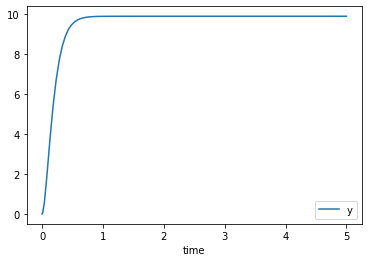

In [ ]:
filter2ndOrder = createFilter2ndOrder(b1, b0, a1, a0)
def compute(model, state0, t0 = 0.0, t_bound = 5, max_step = 0.05):
  solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)
  cnt = 0
  while True:
    message = solver.step()
    y = solver.y
    currentItem = {'time': solver.t, 'y': y[0], 'x1': y[1]}
    yield currentItem
    if (not(solver.status == 'running')):
        break
  return

filter2ndOrderStep = lambda t, state: filter2ndOrder(t, 10, state)
result = compute(filter2ndOrderStep, state0 = [0, 0])
df = pd.DataFrame(result)
df.plot.line('time', 'y')

## Simulation Tools

### Simulation / Computation
Function
```python
def compute
```
streams out (`yield`) the vector $r(t)$ which consists of

|index|name|symbol|unit|
|:-:|-|:-:|:-:|
|0|time|$t$|$s$|
|1|x position|$x$|$m$|
|2|y position|$y$|$m$|
|3|orientation|$\theta$|$rad$|
|4|distance|$s$|$m$|
|5|orientation II|$\theta$|$rad$|
|6||$\int E dt$||
|7|x velocity|$v_x$|$ms^{-1}$|
|8|y velocity|$v_y$|$ms^{-1}$|
|9|angular velocity|$\omega$|$rads^{-1}$|
|10|velocity|$v$|$ms^{-1}$|
|11|angular velocity II|$\omega$|$rads^{-1}$|
|12|current energy|$E$|$J$|
|13|total energy|$E$|$J$|

for numerical computation `RK45` function from `scipy` library is used.


In [ ]:
selectx = lambda item: item['y'][0]       # x position
selecty = lambda item: item['y'][1]       # y position
selectt = lambda item: item['time']       # time
selectv = lambda item: item['dy'][3]      # velocity
selectomega = lambda item: item['dy'][2]  # omega = theta_dot
selecte = lambda item: item['TotalEnergy']# energy
selects = lambda item: item['y'][3]       # displacement

selectors = [selectt, selectx, selecty, selects, selectv, selectomega, selecte]
#         yIndex=0, yIndex=1, yIndex=2, yIndex=3, yIndex=4, yIndex=5, yIndex=6
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.05):
  solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)
  cnt = 0
  lastEnergy = 0
  totalEnergy = 0

#names = ['t', 'x', 'y', 'θ', 's', 'θ2', 'IE', "x'", "y'", 'ω', 'v', 'ω2', 'E']
  while True:
    message = solver.step()
    #currentItem = [solver.t, *solver.y, *model(solver.t, solver.y)]
    currentItem = {'time': solver.t, 'y': solver.y, 'dy': model(solver.t, solver.y)}
    #t, 'solver.y': x, y, theta, s, theta, intE 'model': x', y', theta', velocity, omega, E
    #0,             1, 2, 3,     4,   5,    6,           7,  8,   9,        10,     11,   12  
    # Energy calculation / energy sumation
    currentEnergy = currentItem['dy'][5] #currentNamed['E']
    deltaEnergy = currentEnergy - lastEnergy

    if deltaEnergy > 0:
      totalEnergy = totalEnergy + deltaEnergy

    lastEnergy = currentEnergy
    currentItem['TotalEnergy'] = totalEnergy

    yield currentItem
    if (not(solver.status == 'running')):
        break
  return

### Following given path
Function
```python
def controllerForPath
```
extends given controller which is supposed to reach the goal defined by a single position. Every time when the robot reaches the goal, a new point from the path is readout until the queue of the point is exhausted.

In [ ]:
def controllerForPath(controller, path):
  destinationX, destinationY, destinationOrietation = next(path)
  destinationState = [destinationX, destinationY, destinationOrietation]
  lastReached = False
  #print('Destination set to', destinationState)
  def result(t, currentState):
    nonlocal destinationX # use parent variable
    nonlocal destinationY # use parent variable
    nonlocal destinationState # use parent variable
    nonlocal lastReached # use parent variable

    currentX = currentState[0]
    currentY = currentState[1]
    deltaX = destinationX - currentX
    deltaY = destinationY - currentY
    if (lastReached == False):
      # last point in path was not reached
      if (deltaX * deltaX + deltaY * deltaY < 1e-2):
        # robot is close enought to currentDestination
        try:
          # try to get another point on path
          destinationX, destinationY, destinationOrietation = next(path)
          destinationState = [destinationX, destinationY, destinationOrietation]
          #print('Destination set to', destinationState, 'while in state', currentState)
        except StopIteration:
          # there are no other points
          lastReached = True
    if (lastReached):
      return (0, 0)
    else:
      return controller(t, currentState, destinationState)
  return result

### Robot Model and Controller Connection
Function
```python
def robotModelCreator
```
creates function$f(t, x)$ which is part of differential equation

$\dot x=f(t, x)$

returned `resultRMC` can be used and will be used as that function.

In [ ]:
def robotModelCreator(controllerCreator, path, **kwargs):
  controller_ = controllerCreator(**kwargs)
  savedController = controllerForPath(controller_, path)
  def resultRMC(t, currentState):
    return robot(t, currentState, savedController)
  return resultRMC

### Closure Function for Simulation
function
```python
def simpleCompute
```

In [ ]:
def simpleCompute(computefunc, state0, t0 = 0, t_bound = 200, max_step = 0.05):
  def resultSC(model):
    return computefunc(
        model, state0 = state0, t0 = t0, t_bound = t_bound, max_step = max_step)
  return resultSC

### Simulation Runner
This function uses the simulation description parameter (`experimentsDescription`) and returns a 3D array of results. First dimension along robots, second dimension along time and last dimension along values.

In [ ]:
def runSimulations(
    experimentsDescription, path, 
    state0, t0 = 0, t_bound = 200, max_step = 0.05):

  solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step)

  robots = []
  for currentExperiment in experimentsDescription:
    description = currentExperiment['description']
    robotWithController = robotModelCreator(**description)
    robots.append(solverfunc(robotWithController))

  results = []
  for currentRobot in robots:
    result = []
    for currentState in currentRobot: # readout all states from current moving robot
      for _ in selectors:
        result.append([])
      for index, func in enumerate(selectors):
        result[index].append(func(currentState))
    results.append(result)
  return results

### Path Plotter

In [ ]:
def plotSimulationsPaths(
    experimentsDescription, experimentsResults, path, show = True):
  for currentResult, experiment in zip(experimentsResults, experimentsDescription):
    currentStyle = experiment['plotstyle']

    t_a = currentResult[0]
    x_a = currentResult[1]
    y_a = currentResult[2]
        
    plt.plot(x_a, y_a, **currentStyle)

  pathx = []
  pathy = []
  for x, y, orientation in path:
    pathx.append(x)
    pathy.append(y)

  plt.plot(pathx, pathy, 'b-', label = 'Planned path', lw = 1)
  plt.grid(which = 'both')  
  plt.gca().set_aspect('equal')
  plt.legend(loc = 'best')
  plt.xlabel('$x[m]$')
  plt.ylabel('$y[m]$')
  if show:
    plt.show()    
  return

### Value Plotter

In [ ]:
def plotValueAndTime(
    experimentsDescription, experimentsResults, show = True, 
    xIndex = 0, xLabel = '$t[s]$',
    yIndex = 3, yLabel = '$s[m]$', title = ''):
  for currentResult, experiment in zip(experimentsResults, experimentsDescription):
    t_a = currentResult[xIndex]
    s_a = currentResult[yIndex]
    currentStyle = experiment['plotstyle']

    plt.plot(t_a, s_a, **currentStyle)

  plt.grid(which = 'both')  
  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  plt.title(title)
  if show:
    plt.show()    
  return  

### All in one Plotter

In [ ]:
def plotAllInOne(experimentsDescription, experimentsResults, path):
  fig = plt.figure()# for save picture of figures

  plt.subplot(3, 2, 1)
  plt.title('Path')
  plotSimulationsPaths(
      experimentsDescription, experimentsResults, path, show = False)
  
  plt.subplot(3, 2, 2)
  plt.title('Distance in Time')
  plotValueAndTime(
      experimentsDescription, experimentsResults, show = False, 
      yIndex = 3, yLabel = '$s[m]$')
  plt.legend(loc = 'right')
  
  plt.subplot(3, 2, 3)
  plt.title('Angular velocity in Time')
  plotValueAndTime(
      experimentsDescription, experimentsResults, show = False, 
      yIndex = 5, yLabel = '$\omega[rads^{-1}]$')
  plt.legend(loc = 'lower right')
  
  plt.subplot(3, 2, 4)
  plt.title('Velocity in Time')
  plotValueAndTime(
      experimentsDescription, experimentsResults, show = False, 
      yIndex = 4, yLabel = '$v[ms^{-1}]$')
  plt.legend(loc = 'right')

  plt.subplot(3, 2, 5)
  plt.title('Total Kinetic Energy loss in Time')
  plotValueAndTime(
      experimentsDescription, experimentsResults, show = False, 
      yIndex = 6, yLabel = '$E[J]$')
  plt.legend(loc = 'right')
      
  fig.savefig('plot.png')
  plt.show()    


### Data Extractor


In [ ]:
def ExtractData(experimentsDescription, experimentsResults, path):
  for description, result in zip(experimentsDescription, experimentsResults):
#controllerCreator
    parameters = {**description['description']}
    del parameters['controllerCreator']
    del parameters['path']
    del parameters['omega_ri']

    yield {
        'Experiment': description['name'], 
        'Total distance': str(result[3][-1]), 
        'Total energy': str(result[6][-1]),
        **parameters
        }
  pass

### Table Display

In [ ]:
def displayTable(data):
  df = pd.DataFrame(data)
  display(df)

## Controllers
Following are the controllers which are implemented and compared:

- Lyapunov controller

- Clever Trigonometry Based Controller

- Feedback base control – Circular path

- Advanced controller By_RobinsMathew

- Advanced controller - Circular path

- Advanced controller - Dubins path

- Controller proposed by Kanayama

### Feedback-based controller for  circular path




In [ ]:
def createCircleControllerWithGain(omega_ri, vri, k1, 
  lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)

    deltaX = destinationX - currentX
    deltaY = destinationY - currentY

    velocity = vri
    omega = -2 * k1 * vri * (deltaX * sinTheta - deltaY * cosTheta) / (deltaX * deltaX + deltaY * deltaY)
    
    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit

    return velocity, omega
  return controller

### Advanced controller by RobinsMathew



In [ ]:
def createController_By_RobinsMathew(omega_ri, vri, k1, k2,
  lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
                                     
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)
    
    deltaX = destinationX - currentX
    deltaY = destinationY - currentY
    theta_destination = atan2(deltaY, deltaX)
    theta_error = theta_destination - currentTheta

    Te = math.sin(theta_destination)*deltaX - math.cos(theta_destination)*deltaY
    velocity = vri*math.cos(theta_error)
    omega = omega_ri + k1*vri*Te + k2*vri*math.sin(theta_error)

    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit
      
    return velocity, omega
  return controller

### Lyapunov controller



In [ ]:
def createLyapunovController(omega_ri, vri, k1, k2,
  lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]
    
    destinationX = destinationState[0]
    destinationY = destinationState[1]
    
    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)
    
    deltaX = destinationX - currentX
    deltaY = destinationY - currentY
    theta_destination = atan2(deltaY, deltaX)
    theta_error = theta_destination - currentTheta

    if (theta_error > pi):
      theta_error -= 2 * pi
    if (theta_error < -pi):
      theta_error += 2 * pi

    velocity = vri* math.cos(theta_error)
    omega = k1*theta_error + vri*math.sin(theta_error)*math.cos(theta_error)*(theta_error+k2*theta_destination)/theta_error
    
    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit
 
    return velocity, omega
  return controller

### Clever geometry controller



In [ ]:
def createCleverGeometryController(omega_ri, vri, k1,
  lowVelocityLimit, highVelocityLimit,lowOmegaLimit, highOmegaLimit):
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]
    
    destinationX = destinationState[0]
    destinationY = destinationState[1]
    
    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)
    
    deltaX = destinationX - currentX
    deltaY = destinationY - currentY
    theta_destination = atan2(deltaY, deltaX)
    theta_error = theta_destination - currentTheta

    if (theta_error > pi):
      theta_error -= 2 * pi
    if (theta_error < -pi):
      theta_error += 2 * pi

    velocity = vri *math.cos(theta_error)
    omega = k1 * math.sin(theta_error)

    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit
      
    return velocity, omega
  return controller

### Advanced controller - Dubins path


In [ ]:
def createDubinsController(omega_ri, vri, k1, lowVelocityLimit, highVelocityLimit,lowOmegaLimit, highOmegaLimit):
  minimal_radius = k1
  angle_epsilon = 0.05 # radians
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]
    
    # hacky, because it could be outside interval <-PI, +PI> :(
    while currentTheta < -2 * pi:
      currentTheta = currentTheta + 2 * pi
    while currentTheta > 2 * pi:
      currentTheta = currentTheta - 2 * pi

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    deltaX = destinationX - currentX
    deltaY = destinationY - currentY

    angle_to_destination = atan2(deltaY, deltaX)

    #https://stackoverflow.com/questions/1878907/the-smallest-difference-between-2-angles

    angle_delta = currentTheta - angle_to_destination

    if (angle_delta > pi):
      angle_delta -= 2 * pi
    if (angle_delta < -pi):
      angle_delta += 2 * pi

    if (angle_delta < - angle_epsilon):
      # turn on minimal radius
      velocity = vri
      omega = velocity / minimal_radius
    elif (angle_delta > + angle_epsilon):
      # turn on minimal radius
      velocity = vri
      omega = -velocity / minimal_radius
    else:
      # go straight
      velocity = vri
      omega = 0

    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit

    return velocity, omega
  return controller

### Advanced controller by Kanayama Controller


In [ ]:
def createController_By_Kanayama(omega_ri, vri, k1, k2, k3,
  lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)
    
    deltaX = destinationX - currentX
    deltaY = destinationY - currentY
    theta_destination = atan2(deltaY, deltaX)
    theta_error = theta_destination - currentTheta

    x_ie = cosTheta*deltaX + sinTheta*deltaY
    y_ie = cosTheta*deltaY - sinTheta*deltaX
    velocity = vri*math.cos(theta_error) + k1*x_ie
    omega = omega_ri + k2*vri*y_ie + k3*vri*math.sin(theta_error)

    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit
          
    return velocity, omega
  return controller

## Simulation

### Paths Definition

In [ ]:
# Square path
def pathA():
  yield 0, 0, 0  #X, Y, orientation
  yield 10, 0, 0 #X, Y, orientation
  yield 10, 10, 0#X, Y, orientation
  yield 0, 10, 0 #X, Y, orientation
  yield 0, 0, 0 #X, Y, orientation

In [ ]:
# StraightFoward path
def pathB():
  yield 0, 0, 0 #X, Y, orientation
  yield 10, 0, 0 #X, Y, orientation
  yield 20, 10, 0 #X, Y, orientation
  yield 30, 10, 0 #X, Y, orientation
  yield 25, 20, 0 #X, Y, orientation

In [ ]:
# StraightFoward path with many waypoint
def pathC():
  yield 0, 0, 0 #X, Y, orientation
  x1 = 3
  for x1 in range (3,10):
    yield x1, 0, 0
    x1 = x1 + 1
  yield 10, 0, 0 #X, Y, orientation
  x2 = 12
  y2 = 2
  for x2 in range (12,20):
    yield x2, y2, 0
    x2 = x2 + 1
    y2 = y2 + 1
  yield 20, 10, 0 #X, Y, orientation
  x3 = 24
  for x3 in range(24, 30):
    yield x3, 10, 0
    x3 = x3+1
  yield 30, 10, 0 #X, Y, orientation
  yield 27.5, 15, 0
  yield 26.5, 17, 0
  yield 25.5, 19, 0
  yield 25, 20, 0 #X, Y, orientation

In [ ]:
# Diamond-Shape path
def pathD():
  yield 0, 0, 0 #X, Y, orientation
  yield 10, -5, 0 #X, Y, orientation
  yield 20, 0, 0 #X, Y, orientation
  yield 10, 5, 0 #X, Y, orientation
  yield 0, 0, 0 #X, Y, orientation

In [ ]:
# Sharp turn path
def pathE():
  yield 0, 0, 0 #X, Y, orientation
  yield 0, 5, 0 #X, Y, orientation
  yield 5, 0, 0 #X, Y, orientation
  yield 5, 10, 0 #X, Y, orientation
  yield 25, 0, 0 #X, Y, orientation

### Define your path here

In [ ]:
def pathF():
  #for every single point on path express
  yield 0, 0, 0 #X, Y, orientation
  #repeat it until done
  

In [ ]:
paths = [ 
  {'name': 'Square path', 'func': pathA, 
   'tags' :['Square path', 'Main']},
  {'name': 'Straightforward path', 'func': pathB, 
   'tags' :['Straightforward path', 'Main', 'Supportive']},
  {'name': 'Straightforward path with many waypoints', 'func': pathC, 
   'tags': ['Straightforward path with many waypoints','Main', 'Supportive']},
  {'name': 'Diamond-Shape path', 'func': pathD, 
   'tags': ['Diamond-Shape path','Main']},
  {'name': 'Sharp turn path', 'func': pathE, 
   'tags': ['Sharp turn path','Main']},
  {'name': 'Custom', 'func': pathF, 'tags': ['Custom']} 
   ]

### Experiment Description

In [ ]:
experiments = [
    { 'name': 'Circle [v = 1.0, g = 4]',
      'description':
        {'controllerCreator': createCircleControllerWithGain, 
        'omega_ri': 0,'vri': 1.0, 'k1': 4.0
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'g', 'lw': 1,
        'label': 'Feedback-based controller $G = 4$'
        },      
      'tags': ['Main', 'Circle', 'Low Energy']
    },
    { 'name': 'Circle_2nd [v = 0.8, g = 4]',
      'description':
        {'controllerCreator': createCircleControllerWithGain, 
        'omega_ri': 0,'vri': 0.8, 'k1': 4.0,
        'highVelocityLimit': 0.8
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'r', 'lw': 1,
        'label': 'Feedback-based controller 2nd $G = 4$'
        },      
      'tags': ['Circle']
    },
    { 'name': 'Circle_3rd [v = 0.5, g = 4]',
      'description':
        {'controllerCreator': createCircleControllerWithGain, 
        'omega_ri': 0,'vri': 0.5, 'k1': 4.0,
        'highVelocityLimit': 0.5
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'k', 'lw': 1,
        'label': 'Feedback-based controller 3rd $G = 4$'
        },      
      'tags': ['Circle']
    },
    { 'name': 'Circle [v = 1.0, g = 8]',
      'description':
        {'controllerCreator': createCircleControllerWithGain, 
        'omega_ri': 0,'vri': 1.0, 'k1': 8.0,
        },
      'plotstyle':
        {'linestyle': '--', 'color': 'g', 'lw': 1,
        'label': 'Feedback-based controller $G = 8$'
        },
      'tags': ['Main', 'Low Energy']
    },
    { 'name': 'Dubins',
      'description':
        {'controllerCreator': createDubinsController, 
        'omega_ri': 0, 'vri': 1.0, 'k1': 1.0,
        },
      'plotstyle':
        {'linestyle': '--', 'color': 'maroon', 'lw': 1, 
        'label': 'Dubins-based controller'
        },
      'tags': ['Main', 'Dubins', 'Low Energy']    
    },
    
    { 'name': 'Dubins_2nd',
      'description':
        {'controllerCreator': createDubinsController, 
        'omega_ri': 0, 'vri': 1.1, 'k1': 1.0,
        'highVelocityLimit': 1.1
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'g', 'lw': 1, 
        'label': 'Dubins-based controller 2nd'
        },
      'tags': ['Dubins']     
    },
    { 'name': 'Dubins_3rd',
      'description':
        {'controllerCreator': createDubinsController, 
        'omega_ri': 0, 'vri': 1.15, 'k1': 1.0,
        'highVelocityLimit': 1.15
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'r', 'lw': 1, 
        'label': 'Dubins-based controller 3rd'
        },
      'tags': ['Dubins']     
    },
    { 'name': 'Lyapunov',
      'description':
        {'controllerCreator': createLyapunovController, 
        'omega_ri': 0,'vri': 1.0, 'k1': 5.0, 'k2': 0.01,
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'r', 'lw': 1,
        'label': 'Lyapunov-based controller'
        },
      'tags': ['Main', 'Lyapunov', 'High Energy']
    },    
    { 'name': 'Lyapunov 2nd',
      'description':
        {'controllerCreator': createLyapunovController, 
        'omega_ri': 0,'vri': 1.1, 'k1': 5.0, 'k2': 0.01,
        'highVelocityLimit': 1.1
        },
      'plotstyle':
        {'linestyle': '--', 'color': 'g', 'lw': 1,
        'label': 'Lyapunov-based controller vri = 1.1 m/s'
        },
      'tags': ['Lyapunov']
    },
    { 'name': 'Lyapunov 3rd',
      'description':
        {'controllerCreator': createLyapunovController, 
        'omega_ri': 0,'vri': 1.15, 'k1': 5.0, 'k2': 0.01,
        'highVelocityLimit': 1.15
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'indigo', 'lw': 1,
        'label': 'Lyapunov-based controller vri = 1.15 m/s'
        },
      'tags': ['Lyapunov']
    },

    { 'name': 'Geometry',
      'description':
        {'controllerCreator': createCleverGeometryController, 
        'omega_ri': 0,'vri': 1.0, 'k1': 7.0,
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'indigo', 'lw': 1,
        'label': 'Geometry-based controller'
        },
      'tags': ['Main', 'High Energy']
    },
    { 'name': 'RobinsMathew',
      'description':
        {'controllerCreator': createController_By_RobinsMathew, 
        'omega_ri':0, 'vri': 1.0, 'k1': 1.5, 'k2': 6.5,
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'k', 'lw': 1, 
        'label': 'RobinsMathew-based controller'
        },
      'tags': ['Main', 'RobinsMathew', 'High Energy']    
    },

    { 'name': 'RobinsMathew 2nd',
      'description':
        {'controllerCreator': createController_By_RobinsMathew, 
        'omega_ri':0, 'vri': 1.1, 'k1': 1.5, 'k2': 6.5,
        'highVelocityLimit': 1.1
        },
      'plotstyle':
        {'linestyle': '-', 'color': 'r', 'lw': 1, 
        'label': 'RobinsMathew-based controller 2nd'
        },
      'tags': ['RobinsMathew']    
    },

    { 'name': 'RobinsMathew 3rd',
      'description':
        {'controllerCreator': createController_By_RobinsMathew, 
        'omega_ri':0, 'vri': 1.15, 'k1': 1.5, 'k2': 6.5,
        'highVelocityLimit': 1.15
        },
      'plotstyle':
        {'linestyle': '--', 'color': 'g', 'lw': 1, 
        'label': 'RobinsMathew-based controller 3rd'
        },
      'tags': ['RobinsMathew']    
    },
    
    { 'name': 'Kanayama',
      'description':
        {'controllerCreator': createController_By_Kanayama, 
        'omega_ri':0, 'vri': 1.0, 'k1': 0.001, 'k2': 0.1, 'k3': 5,
        },
      'plotstyle':
        {'linestyle': '--', 'color': 'k', 'lw': 1, 
        'label': 'Kanayama-based controller'
        },
      'tags': ['Main', 'High Energy']
    }
    #insert you new controller here
    ]

In [ ]:
def ApplyExperimentsOnPath(path, experiments = experiments,
  #shared limits on velicities and omegas
  slVelocityLow = 0.2,
  slVelocityHigh = 1.0,
  slOmegaLow = -0.75,
  slOmegaHigh = 0.75):

  #MovementLimits could be redefined in controllers description
  MovementLimits = {'lowVelocityLimit': slVelocityLow, 
    'highVelocityLimit': slVelocityHigh, 
    'lowOmegaLimit': slOmegaLow, 
    'highOmegaLimit': slOmegaHigh}

  result = []
  for item in experiments:
    newExperiment = {
        'name': item['name'],
        'description': {**MovementLimits, **item['description'], 'path': path()},
        'plotstyle': {**item['plotstyle']},
        'tags': item['tags']
    }
    result.append(newExperiment)

  return result

### Execution

In [ ]:

#just those paths which tags attribute cointains tagValuePaths will be used for experiments
tagValuePaths = 'main'
selectedPaths = list(filter(lambda item: tagValuePaths in item['tags'], paths))
#just those described experiment which contains inside tags tagValue will be executed
tagValue = 'Main' #main experiment, 
selectedExperimentsDescription = list(filter(lambda item: tagValue in item['tags'], experiments))

def executeSelectedExperiments(
    experimentsDescription = selectedExperimentsDescription,
    paths = selectedPaths):
  allResults = [] #storage for all experiments

  for pathDesc in paths: # for all paths
    currentPath = pathDesc['func'] 
    experiments = ApplyExperimentsOnPath(
        path = currentPath, 
        experiments = experimentsDescription) # create experiments for currentPath

    p0 = None
    if robot == robotWithDynamic:
      p0 = np.array([start_x, start_y, start_theta, 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
    else:
      p0 = np.array([start_x, start_y, start_theta, 0, 0, 0]) # x0=0, y0=0,theta

    #execute all experiments
    results = runSimulations(
      experimentsDescription = experiments, path = currentPath(),
      state0 = p0, t0 = 0, t_bound = 100, max_step = 0.05) 
    
    #retrieve text values from experiments
    text = list(ExtractData(experimentsDescription = experiments, 
                            experimentsResults = results, path = currentPath()))   
    
    #store experiments results
    allResults.append({
        'pathDesc': pathDesc,
        'description': experimentsDescription,
        'results': results,
        'texts': text})
  return allResults
  
allResults = executeSelectedExperiments(
    selectedExperimentsDescription, selectedPaths)

## Simulation results

### Simulation text results

In [ ]:
def textOutput(allResults):
  for item in allResults:
    pathDesc = item['pathDesc']
    #experimentsDescription = item['description']
    #results = item['results']  
    text = item['texts']

    print('*' * 30)
    print('*', 'Path name:', pathDesc['name'])
    print('*' * 30)
    displayTable(text)
    
textOutput(allResults)

### Simulation image output size settings

In [ ]:
smallImages = False
if smallImages:
  plt.rcParams["font.size"] = "10"
  plt.rcParams["figure.figsize"] = (15, 10)
else:
  plt.rcParams["font.size"] = "18"
  plt.rcParams["figure.figsize"] = (25, 24)

### Simulation all visualizations

In [ ]:
def allVisualizations(allResults):
  for item in allResults:
    #path = item['path']
    pathDesc = item['pathDesc']
    experimentsDescription = item['description']
    results = item['results']  
    #text = item['texts']
    plotAllInOne(
      experimentsDescription = experimentsDescription,
      experimentsResults = results, 
      path = pathDesc['func']())
  
allVisualizations(allResults)

### Simulation paths visualizations

In [ ]:
def pathVisualizations(allResults):
  for item in allResults:
    #path = item['path']
    pathDesc = item['pathDesc']
    experimentsDescription = item['description']
    results = item['results']  
    #text = item['texts']
    plotSimulationsPaths(
      experimentsDescription = experimentsDescription,
      experimentsResults = results, 
      path = pathDesc['func']())
    
pathVisualizations(allResults)

### Simulation robot distance in time visualization

In [ ]:
def distanceVisualization(allResults):
  for item in allResults:
    #path = item['path']
    #pathDesc = item['pathDesc']
    experimentsDescription = item['description']
    results = item['results']  
    #text = item['texts']
    plotValueAndTime(
        experimentsDescription = experimentsDescription, 
        experimentsResults = results)

distanceVisualization(allResults)    

### Simulation robot energy in time visualization

In [ ]:
def energyVisualization(allResults):
  for item in allResults:
    #path = item['path']
    #pathDesc = item['pathDesc']
    experimentsDescription = item['description']
    results = item['results']  
    #text = item['texts']
    plotValueAndTime(
      experimentsDescription = experimentsDescription, 
      experimentsResults = results, yIndex = 6, yLabel = '$E[J]$')
    
energyVisualization(allResults)    

## Interactive Simulation

In [ ]:
from ipywidgets import interact

exTags = []
for item in experiments:
  for tag in item['tags']:
    if not tag in exTags:
      exTags.append(tag)

pathTags = []
for item in paths:
  for tag in item['tags']:
    if not tag in pathTags:
      pathTags.append(tag)

visualizations = {
    'text': textOutput,
    'all': allVisualizations,
    'path': pathVisualizations,
    'distance': distanceVisualization,
    'energy': energyVisualization,
}

oldpathTag = None
oldexperimTag = None

def runIt(experimTag, pathTag, visualizations, smallImages):
  global oldpathTag
  global oldexperimTag
  global allResults

  if smallImages:
    plt.rcParams["font.size"] = "15"
    plt.rcParams["figure.figsize"] = (22, 22)
  else:
    plt.rcParams["font.size"] = "20"
    plt.rcParams["figure.figsize"] = (35, 35)

  if not((experimTag == oldexperimTag) & (pathTag == oldpathTag)):
    print('Simulating, please be patient')

    # select appropriate paths
    selectedPaths = list(filter(lambda item: pathTag in item['tags'], paths))
    # select appropriate experiments
    selectedExperimentsDescription = list(filter(lambda item: experimTag in item['tags'], experiments))

    # collect results
    allResults = executeSelectedExperiments(
        selectedExperimentsDescription, selectedPaths)
    
  visualizations(allResults)
  oldpathTag = pathTag
  oldexperimTag = experimTag

interact(runIt,  
         experimTag=exTags,
         pathTag=pathTags,
         visualizations=visualizations, smallImages=True)

interactive(children=(Dropdown(description='experimTag', options=('Main', 'Circle', 'Low Energy', 'Dubins', 'L…

<function __main__.runIt(experimTag, pathTag, visualizations, smallImages)>